In [1]:
import sys
import os

# Get the parent directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Add the parent directory to sys.path
sys.path.append(parent_dir)

In [4]:
import torch
from neuromancer import psl
from torch.utils.data import DataLoader
from matplotlib.lines import Line2D
from neuromancer.system import Node, System
from neuromancer.dynamics import integrators
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.loggers import BasicLogger
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.modules import blocks
from neuromancer.plot import pltOL
import matplotlib.pyplot as plt
torch.manual_seed(0)
# For now, we use CPU till we fix the cuda utilization error
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")


### Plotting Open Loop System

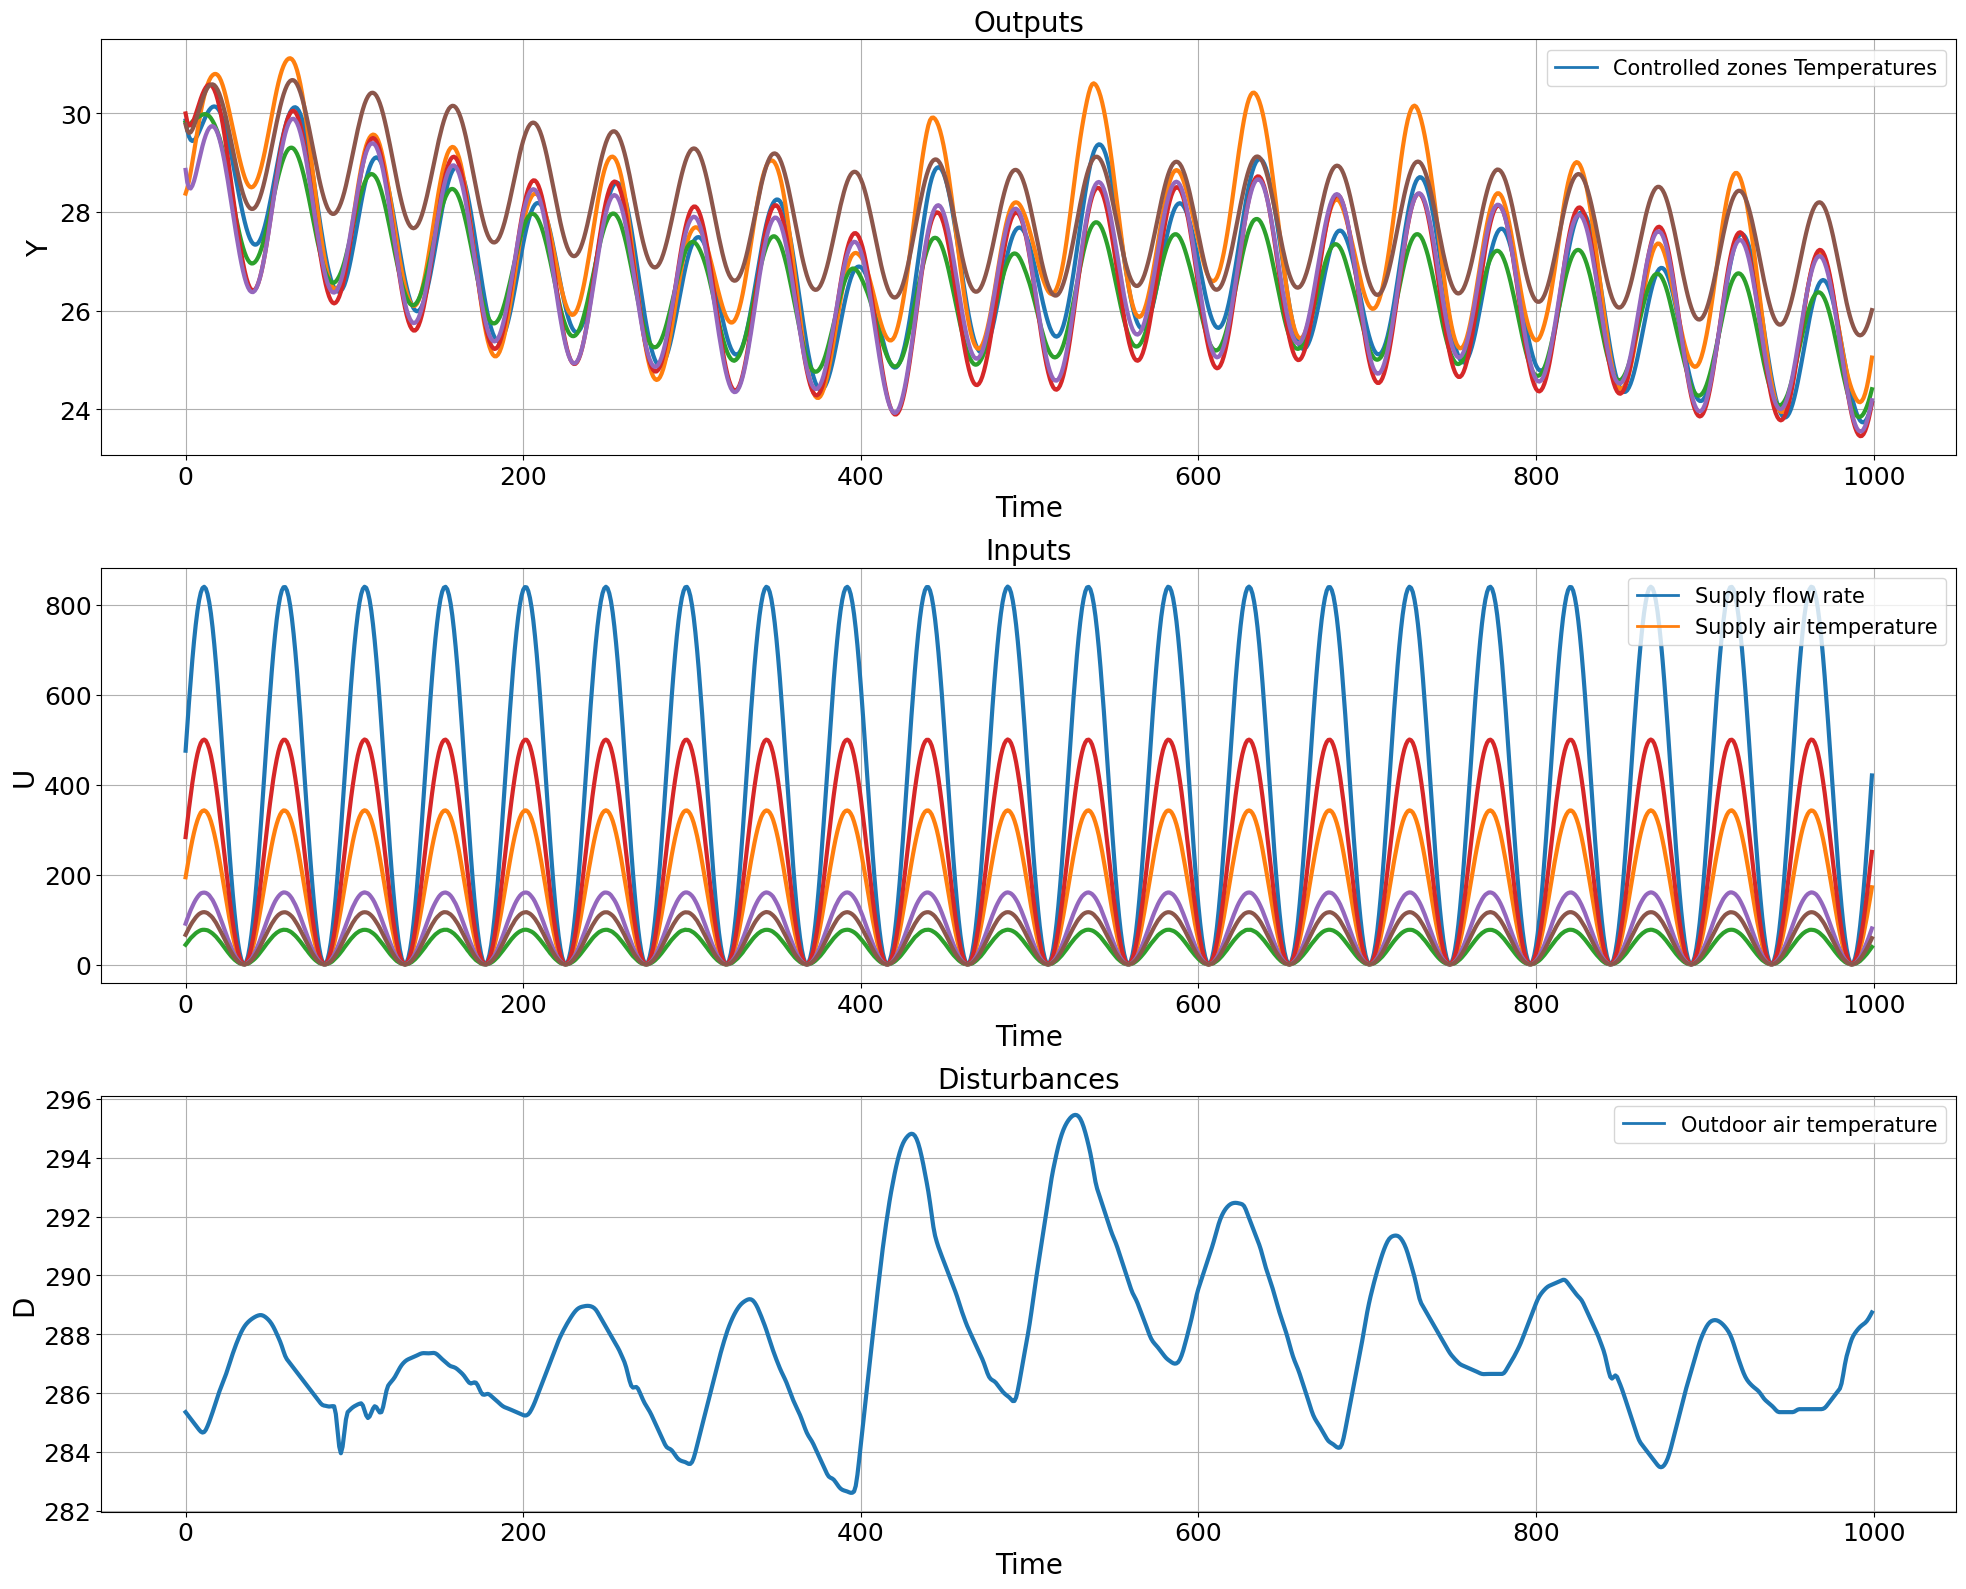

In [5]:
gt_model_name = "LinearReno_ROM40"
gt_model = psl.systems[gt_model_name]()

ts = gt_model.ts
nx = gt_model.nx
ny = gt_model.ny
nu = gt_model.nu
nd = gt_model.nd

raw = gt_model.simulate(nsim=1000)
fig, ax = pltOL(Y=raw['Y'], U=raw['U'], D=raw['D'])
# add custom legends to plots
custom_lines_1 = [Line2D([0], [0], color='tab:blue', lw=2, linestyle='-')]
custom_lines_2 = [Line2D([0], [0], color='tab:blue', lw=2, linestyle='-'),
                    Line2D([0], [0], color='tab:orange', lw=2, linestyle='-')]
ax[0, 0].legend(custom_lines_1, ['Controlled zones Temperatures'], fontsize=15, loc="best")
ax[1, 0].legend(custom_lines_2, ['Supply flow rate', 'Supply air temperature'], fontsize=15, loc="best")
ax[2, 0].legend(custom_lines_1, ['Outdoor air temperature'], fontsize=15, loc="best")

### Getting the Training Data

In [6]:
def normalize(x, mean, std):
    return (x - mean) / std

def get_data(sys, nsim, nsteps, ts, bs):
    """
    :param nsteps: (int) Number of timesteps for each batch of training data
    :param sys: (psl.system)
    :param ts: (float) step size
    :param bs: (int) batch size

    """
    train_sim, dev_sim, test_sim = [sys.simulate(nsim=nsim, ts=ts) for i in range(3)]
    nx = sys.nx
    nu = sys.nu
    nd = sys.nd
    ny = sys.ny
    nbatch = nsim//nsteps
    length = (nsim//nsteps) * nsteps

    mean_x = gt_model.stats['X']['mean']
    std_x = gt_model.stats['X']['std']
    mean_y = gt_model.stats['Y']['mean']
    std_y = gt_model.stats['Y']['std']
    mean_u = gt_model.stats['U']['mean']
    std_u = gt_model.stats['U']['std']
    mean_d = gt_model.stats['D']['mean']
    std_d = gt_model.stats['D']['std']

    trainX = normalize(train_sim['X'][:length], mean_x, std_x)
    trainX = trainX.reshape(nbatch, nsteps, nx)
    trainX = torch.tensor(trainX, dtype=torch.float32)
    trainY = normalize(train_sim['Y'][:length], mean_y, std_y)
    trainY = trainY.reshape(nbatch, nsteps, ny)
    trainY = torch.tensor(trainY, dtype=torch.float32)
    trainU = normalize(train_sim['U'][:length], mean_u, std_u)
    trainU = trainU.reshape(nbatch, nsteps, nu)
    trainU = torch.tensor(trainU, dtype=torch.float32)
    trainD = normalize(train_sim['D'][:length], mean_d, std_d)
    trainD = trainD.reshape(nbatch, nsteps, nd)
    trainD = torch.tensor(trainD, dtype=torch.float32)
    train_data = DictDataset({'X': trainX, 'yn': trainY[:, 0:1, :],
                              'Y': trainY,
                              'U': trainU,
                              'D': trainD}, name='train')
    train_loader = DataLoader(train_data, batch_size=bs,
                              collate_fn=train_data.collate_fn, shuffle=True)

    devX = normalize(dev_sim['X'][:length], mean_x, std_x)
    devX = devX.reshape(nbatch, nsteps, nx)
    devX = torch.tensor(devX, dtype=torch.float32)
    devY = normalize(dev_sim['Y'][:length], mean_y, std_y)
    devY = devY.reshape(nbatch, nsteps, ny)
    devY = torch.tensor(devY, dtype=torch.float32)
    devU = normalize(dev_sim['U'][:length], mean_u, std_u)
    devU = devU[:length].reshape(nbatch, nsteps, nu)
    devU = torch.tensor(devU, dtype=torch.float32)
    devD = normalize(dev_sim['D'][:length], mean_d, std_d)
    devD = devD[:length].reshape(nbatch, nsteps, nd)
    devD = torch.tensor(devD, dtype=torch.float32)
    dev_data = DictDataset({'X': devX, 'yn': devY[:, 0:1, :],
                            'Y': devY,
                            'U': devU,
                            'D': devD}, name='dev')
    dev_loader = DataLoader(dev_data, batch_size=bs,
                            collate_fn=dev_data.collate_fn, shuffle=True)

    testX = normalize(test_sim['X'][:length], mean_x, std_x)
    testX = testX.reshape(1, nbatch*nsteps, nx)
    testX = torch.tensor(testX, dtype=torch.float32)
    testY = normalize(test_sim['Y'][:length], mean_y, std_y)
    testY = testY.reshape(1, nbatch*nsteps, ny)
    testY = torch.tensor(testY, dtype=torch.float32)
    testU = normalize(test_sim['U'][:length], mean_u, std_u)
    testU = testU.reshape(1, nbatch * nsteps, nu)
    testU = torch.tensor(testU, dtype=torch.float32)
    testD = normalize(test_sim['D'][:length], mean_d, std_d)
    testD = testD.reshape(1, nbatch*nsteps, nd)
    testD = torch.tensor(testD, dtype=torch.float32)
    test_data = {'X': testX, 'yn': testY[:, 0:1, :],
                 'Y': testY, 'U': testU, 'D': testD,
                 'name': 'test'}

    return train_loader, dev_loader, test_data

In [7]:
def update_nsteps_all(train_loader, dev_loader, new_nsteps, batch_size):
    """
    Updates the time sequence length (nsteps) for train, dev, and test datasets.

    :param train_loader: (DataLoader) Original train DataLoader
    :param dev_loader: (DataLoader) Original dev DataLoader
    :param test_data: (dict) Original test dataset
    :param new_nsteps: (int) New sequence length
    :param batch_size: (int) Batch size for the new DataLoaders

    :return: (DataLoader, DataLoader, dict) Updated train_loader, dev_loader, and test_data
    """

    def reshape_data(tensor, new_nsteps):
        """ Ensures the tensor is sliced properly and reshaped safely """
        total_elements = tensor.shape[0] * tensor.shape[1]  # Compute total available elements
        nbatch = total_elements // new_nsteps  # Compute new number of batches
        length = nbatch * new_nsteps  # Ensure full sequences

        return torch.flatten(tensor, 0, 1)[:length].reshape(nbatch, new_nsteps, tensor.shape[-1])

    def process_loader(loader, name):
        """
        Extracts data from a DataLoader, reshapes it with new_nsteps, and returns a new DataLoader.
        """
        datadict = loader.dataset.datadict

        # Reshape data with new_nsteps
        newX = reshape_data(datadict["X"], new_nsteps)
        newY = reshape_data(datadict["Y"], new_nsteps)
        newU = reshape_data(datadict["U"], new_nsteps)
        newD = reshape_data(datadict["D"], new_nsteps)

        # Create new dataset
        new_data = DictDataset({'X': newX, 'yn': newY[:, 0:1, :], 'Y': newY, 'U': newU, 'D': newD}, name=name)

        # Create new DataLoader
        new_loader = DataLoader(new_data, batch_size=batch_size, collate_fn=new_data.collate_fn, shuffle=True)
        return new_loader

    # Process train and dev loaders
    new_train_loader = process_loader(train_loader, "train")
    new_dev_loader = process_loader(dev_loader, "dev")

    return new_train_loader, new_dev_loader




In [8]:
nsim = 1000   # number of simulation steps in the dataset
nsteps = 50 # number of prediction horizon steps in the loss function
bs = 100       # minibatching batch size
train_loader, dev_loader, test_data = get_data(gt_model, nsim, nsteps, ts, bs)



### NODE

In [9]:
#NODE:

n_latent = 32  # latent state space dimension

# latent state estimator
encoder = blocks.MLP(ny, n_latent, bias=True,
                linear_map=torch.nn.Linear,
                nonlin=torch.nn.ReLU,
                hsizes=[64, 64])
encode_sym = Node(encoder, ['yn'], ['xn'], name='encoder')



# construct latent NODE model in Neuromancer
fx = blocks.MLP(n_latent+nu+nd, n_latent, bias=True,
                    linear_map=torch.nn.Linear,
                    nonlin=torch.nn.Tanh,
                    hsizes=[128, 128])


# integrate NODE with adjoint-based solver
fxRK4 = integrators.RK4(fx, h=ts)
model = Node(fxRK4, ['xn', 'U', 'D'], ['xn'], name='NODE')

# latent output model
decoder = blocks.MLP(n_latent, ny, bias=True,
                linear_map=torch.nn.Linear,
                nonlin=torch.nn.ReLU,
                hsizes=[64, 64])
decode_sym = Node(decoder, ['xn'], ['y'], name='decoder')

# latent NODE rollout
dynamics_model = System([model, decode_sym], name='system', nsteps=nsteps)

In [47]:
fx

MLP(
  (nonlin): ModuleList(
    (0-1): 2 x Tanh()
    (2): Identity()
  )
  (linear): ModuleList(
    (0): Linear(in_features=39, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=32, bias=True)
  )
)

In [46]:
print(torch.min(fx.forward
                (torch.rand(1,n_latent+nu+nd))))

tensor(-0.2801, grad_fn=<MinBackward1>)


In [190]:
# %% Constraints + losses:
y = variable("Y")
yhat = variable('y')

# trajectory tracking loss
reference_loss = 5.*(yhat == y)^2
reference_loss.name = "ref_loss"

# one-step tracking loss
onestep_loss = 1.*(yhat[:, 1, :] == y[:, 1, :])^2
onestep_loss.name = "onestep_loss"


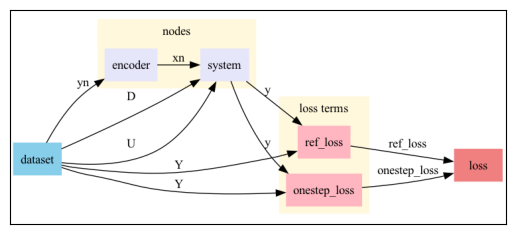

In [191]:

# putting things together
#nodes = [encode_sym, dynamics_model]
objectives = [reference_loss, onestep_loss]
constraints = []

# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints)

# construct constrained optimization problem
problem = Problem([encode_sym,dynamics_model], loss)
# plot computational graph
problem.show()

### Training the SINDy Model

In [192]:
optimizer = torch.optim.AdamW(problem.parameters(),
                                lr=.001)
logger = BasicLogger(args=None, savedir='test', verbosity=1,
                        stdout=['dev_loss', 'train_loss'])

trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    test_data,
    optimizer,
    patience=500,
    epochs=20000,
    eval_metric="dev_loss",
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="dev_loss",
    logger=logger,
    
)


None
Number of parameters: 39110


In [193]:
best_model = trainer.train()
trainer.model.load_state_dict(best_model)

epoch: 0	train_loss: 54.53853	dev_loss: 28.38385	eltime:  0.65211
epoch: 1	train_loss: 53.81127	dev_loss: 28.03308	eltime:  0.71302
epoch: 2	train_loss: 53.22043	dev_loss: 27.67871	eltime:  0.76958
epoch: 3	train_loss: 52.62725	dev_loss: 27.28381	eltime:  0.82401
epoch: 4	train_loss: 51.95583	dev_loss: 26.84014	eltime:  0.87998
epoch: 5	train_loss: 51.17675	dev_loss: 26.34544	eltime:  0.94618
epoch: 6	train_loss: 50.30716	dev_loss: 25.79354	eltime:  1.00986
epoch: 7	train_loss: 49.33712	dev_loss: 25.15777	eltime:  1.06632
epoch: 8	train_loss: 48.18286	dev_loss: 24.40140	eltime:  1.12500
epoch: 9	train_loss: 46.80251	dev_loss: 23.49791	eltime:  1.18673
epoch: 10	train_loss: 45.16596	dev_loss: 22.43635	eltime:  1.24491
epoch: 11	train_loss: 43.25172	dev_loss: 21.20050	eltime:  1.30116
epoch: 12	train_loss: 41.03558	dev_loss: 19.77487	eltime:  1.36012
epoch: 13	train_loss: 38.50077	dev_loss: 18.15027	eltime:  1.41734
epoch: 14	train_loss: 35.63176	dev_loss: 16.32236	eltime:  1.47113
epoch

<All keys matched successfully>

### Closed Loop System Rollout

In [195]:
# update the rollout length based on the test data
problem.nodes[1].nsteps = test_data['Y'].shape[1]

with torch.no_grad():
    test_output = problem(test_data)

def denormalize(x, mean, std):
    return (x * std) + mean

pred_traj = denormalize(test_output['test_y'], gt_model.stats["Y"]["mean"], gt_model.stats["Y"]["std"]).reshape(-1, ny).T
true_traj = denormalize(test_data['Y'], gt_model.stats["Y"]["mean"], gt_model.stats["Y"]["std"]).reshape(-1, ny).T
input_traj = denormalize(test_data['U'], gt_model.stats["U"]["mean"], gt_model.stats["U"]["std"]).reshape(-1, nu).T
dist_traj = denormalize(test_data['D'], gt_model.stats["D"]["mean"], gt_model.stats["D"]["std"]).reshape(-1, nd).T


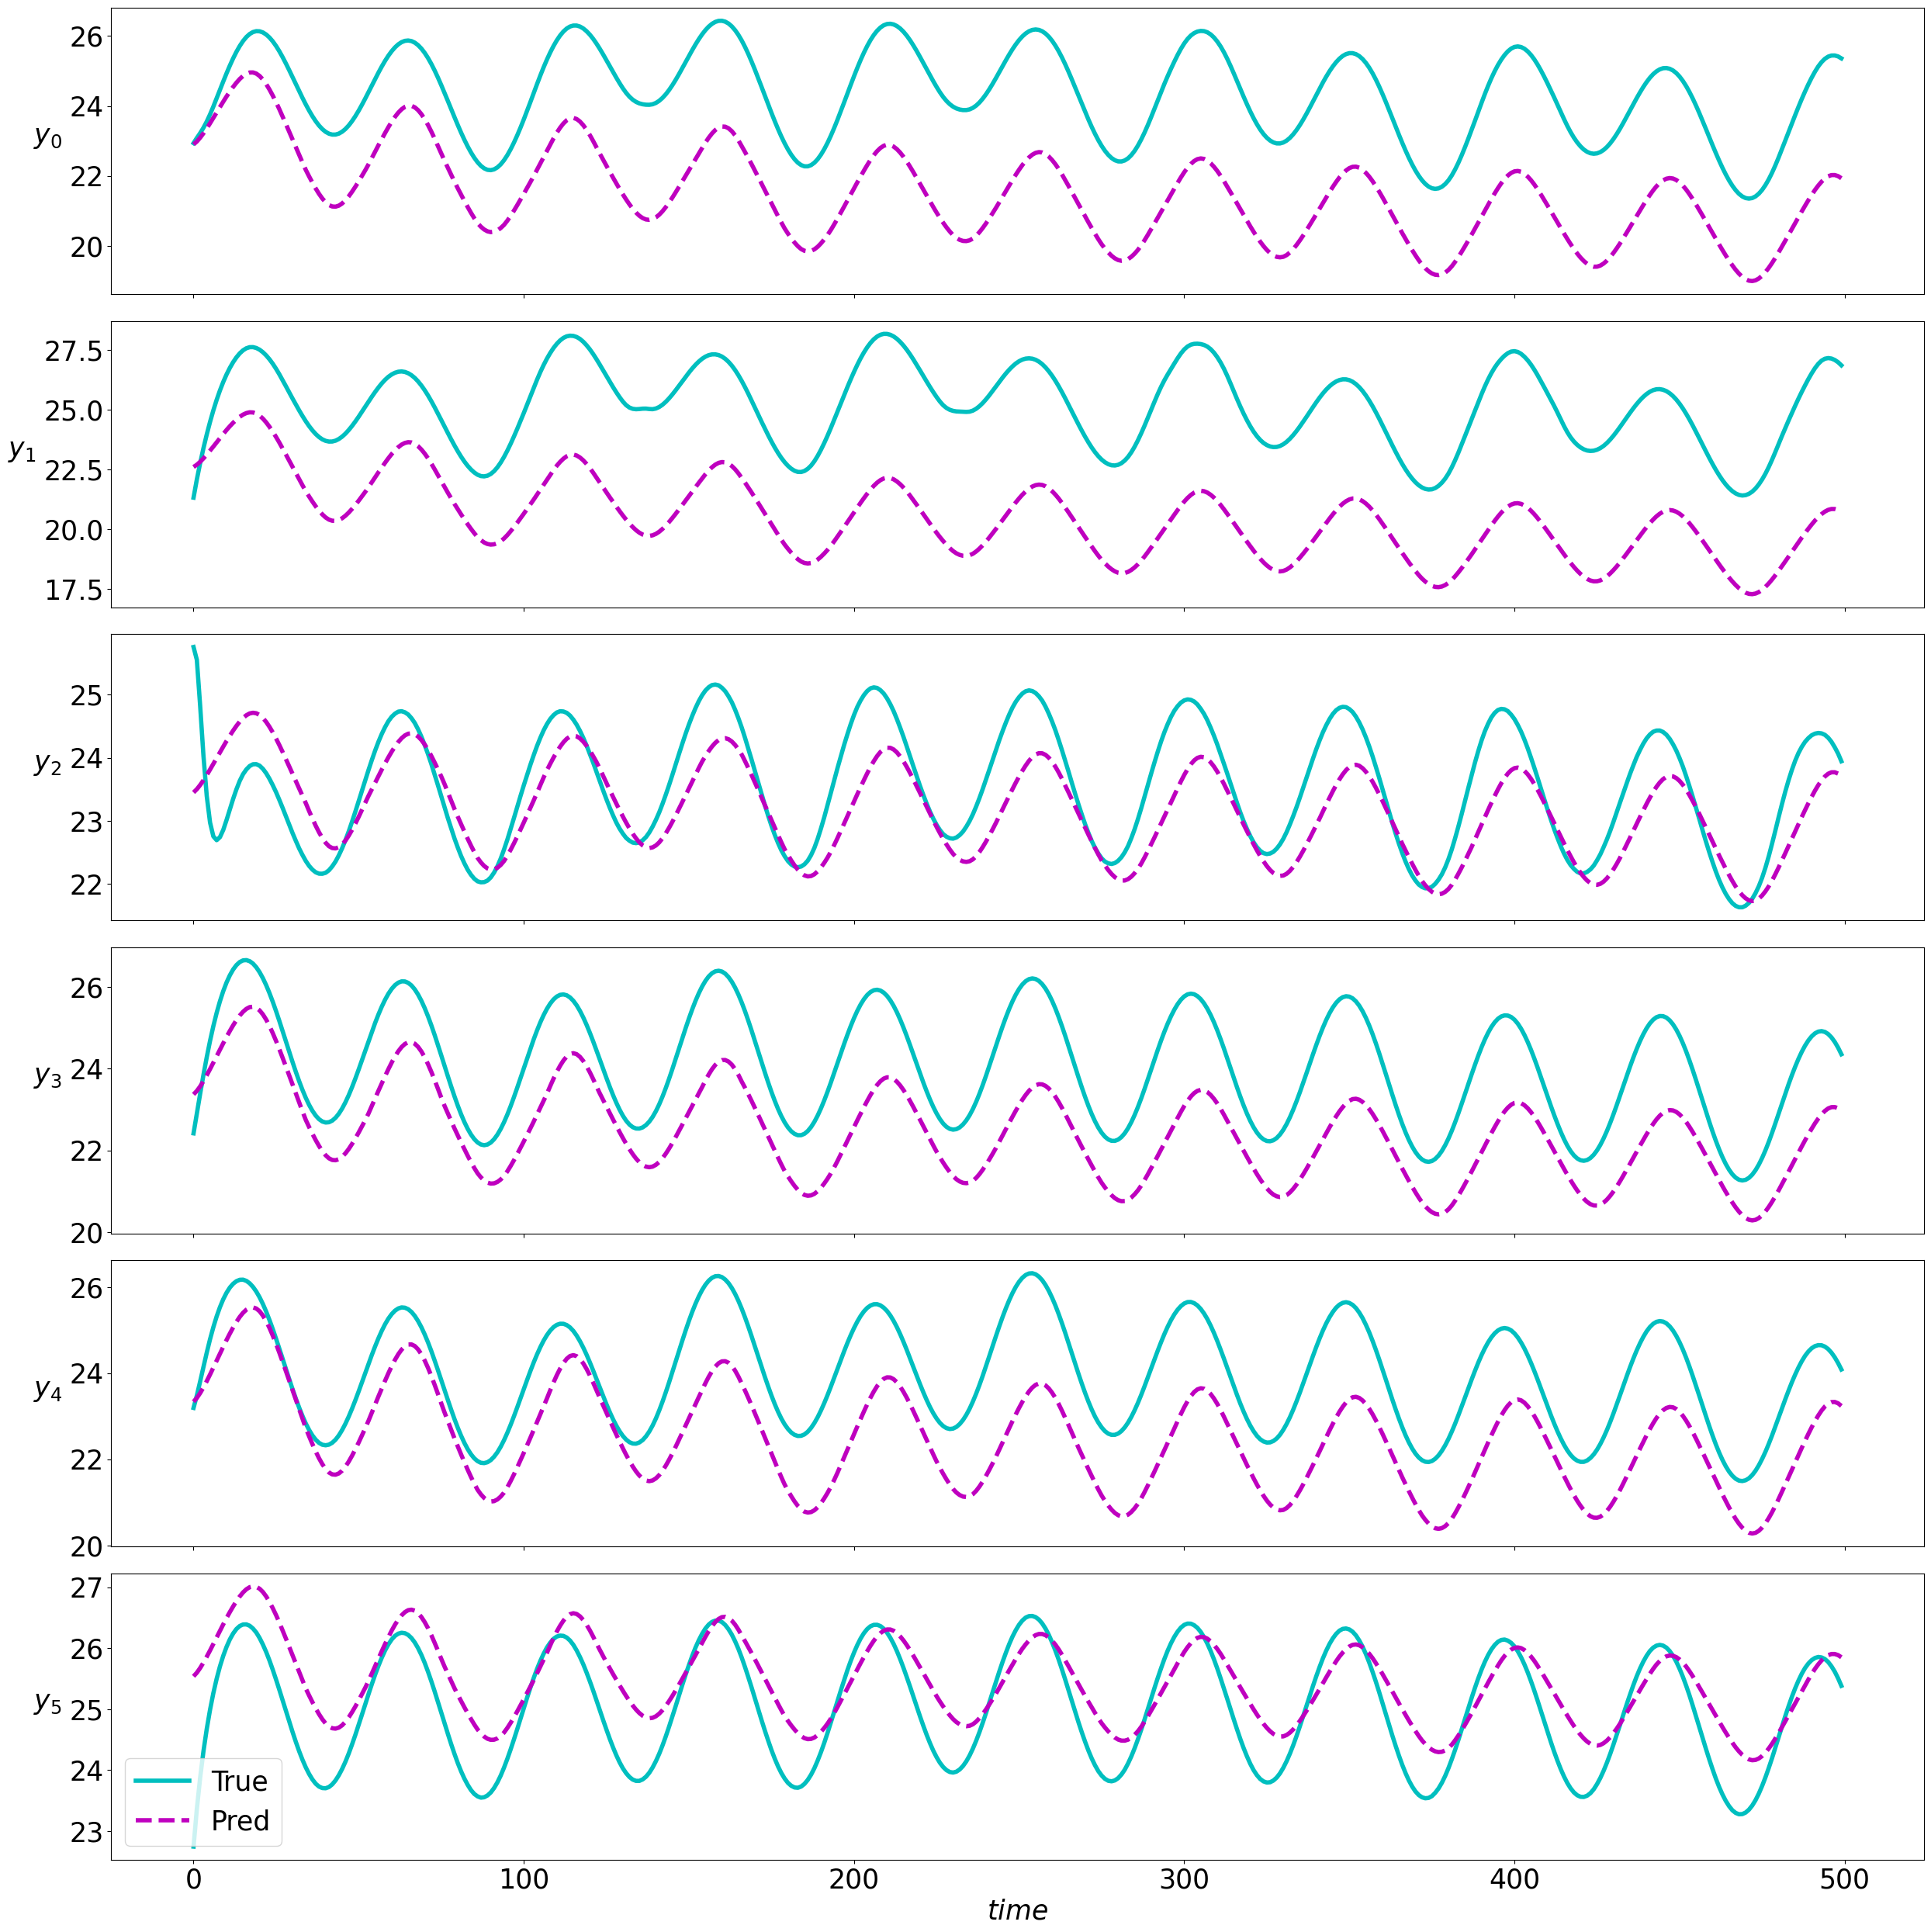

In [196]:

plt_nsteps = 500
figsize = 25
fig, ax = plt.subplots(ny, figsize=(figsize, figsize))
labels = [f'$y_{k}$' for k in range(len(true_traj))]
for row, (t1, t2, label) in enumerate(zip(true_traj, pred_traj, labels)):
    if ny > 1:
        axe = ax[row]
    else:
        axe = ax
    axe.set_ylabel(label, rotation=0, labelpad=20, fontsize=figsize)
    axe.plot(t1[:plt_nsteps], 'c', linewidth=4.0, label='True')
    axe.plot(t2[:plt_nsteps], 'm--', linewidth=4.0, label='Pred')
    axe.tick_params(labelbottom=False, labelsize=figsize)
axe.tick_params(labelbottom=True, labelsize=figsize)
axe.legend(fontsize=figsize)
axe.set_xlabel('$time$', fontsize=figsize)
plt.tight_layout()

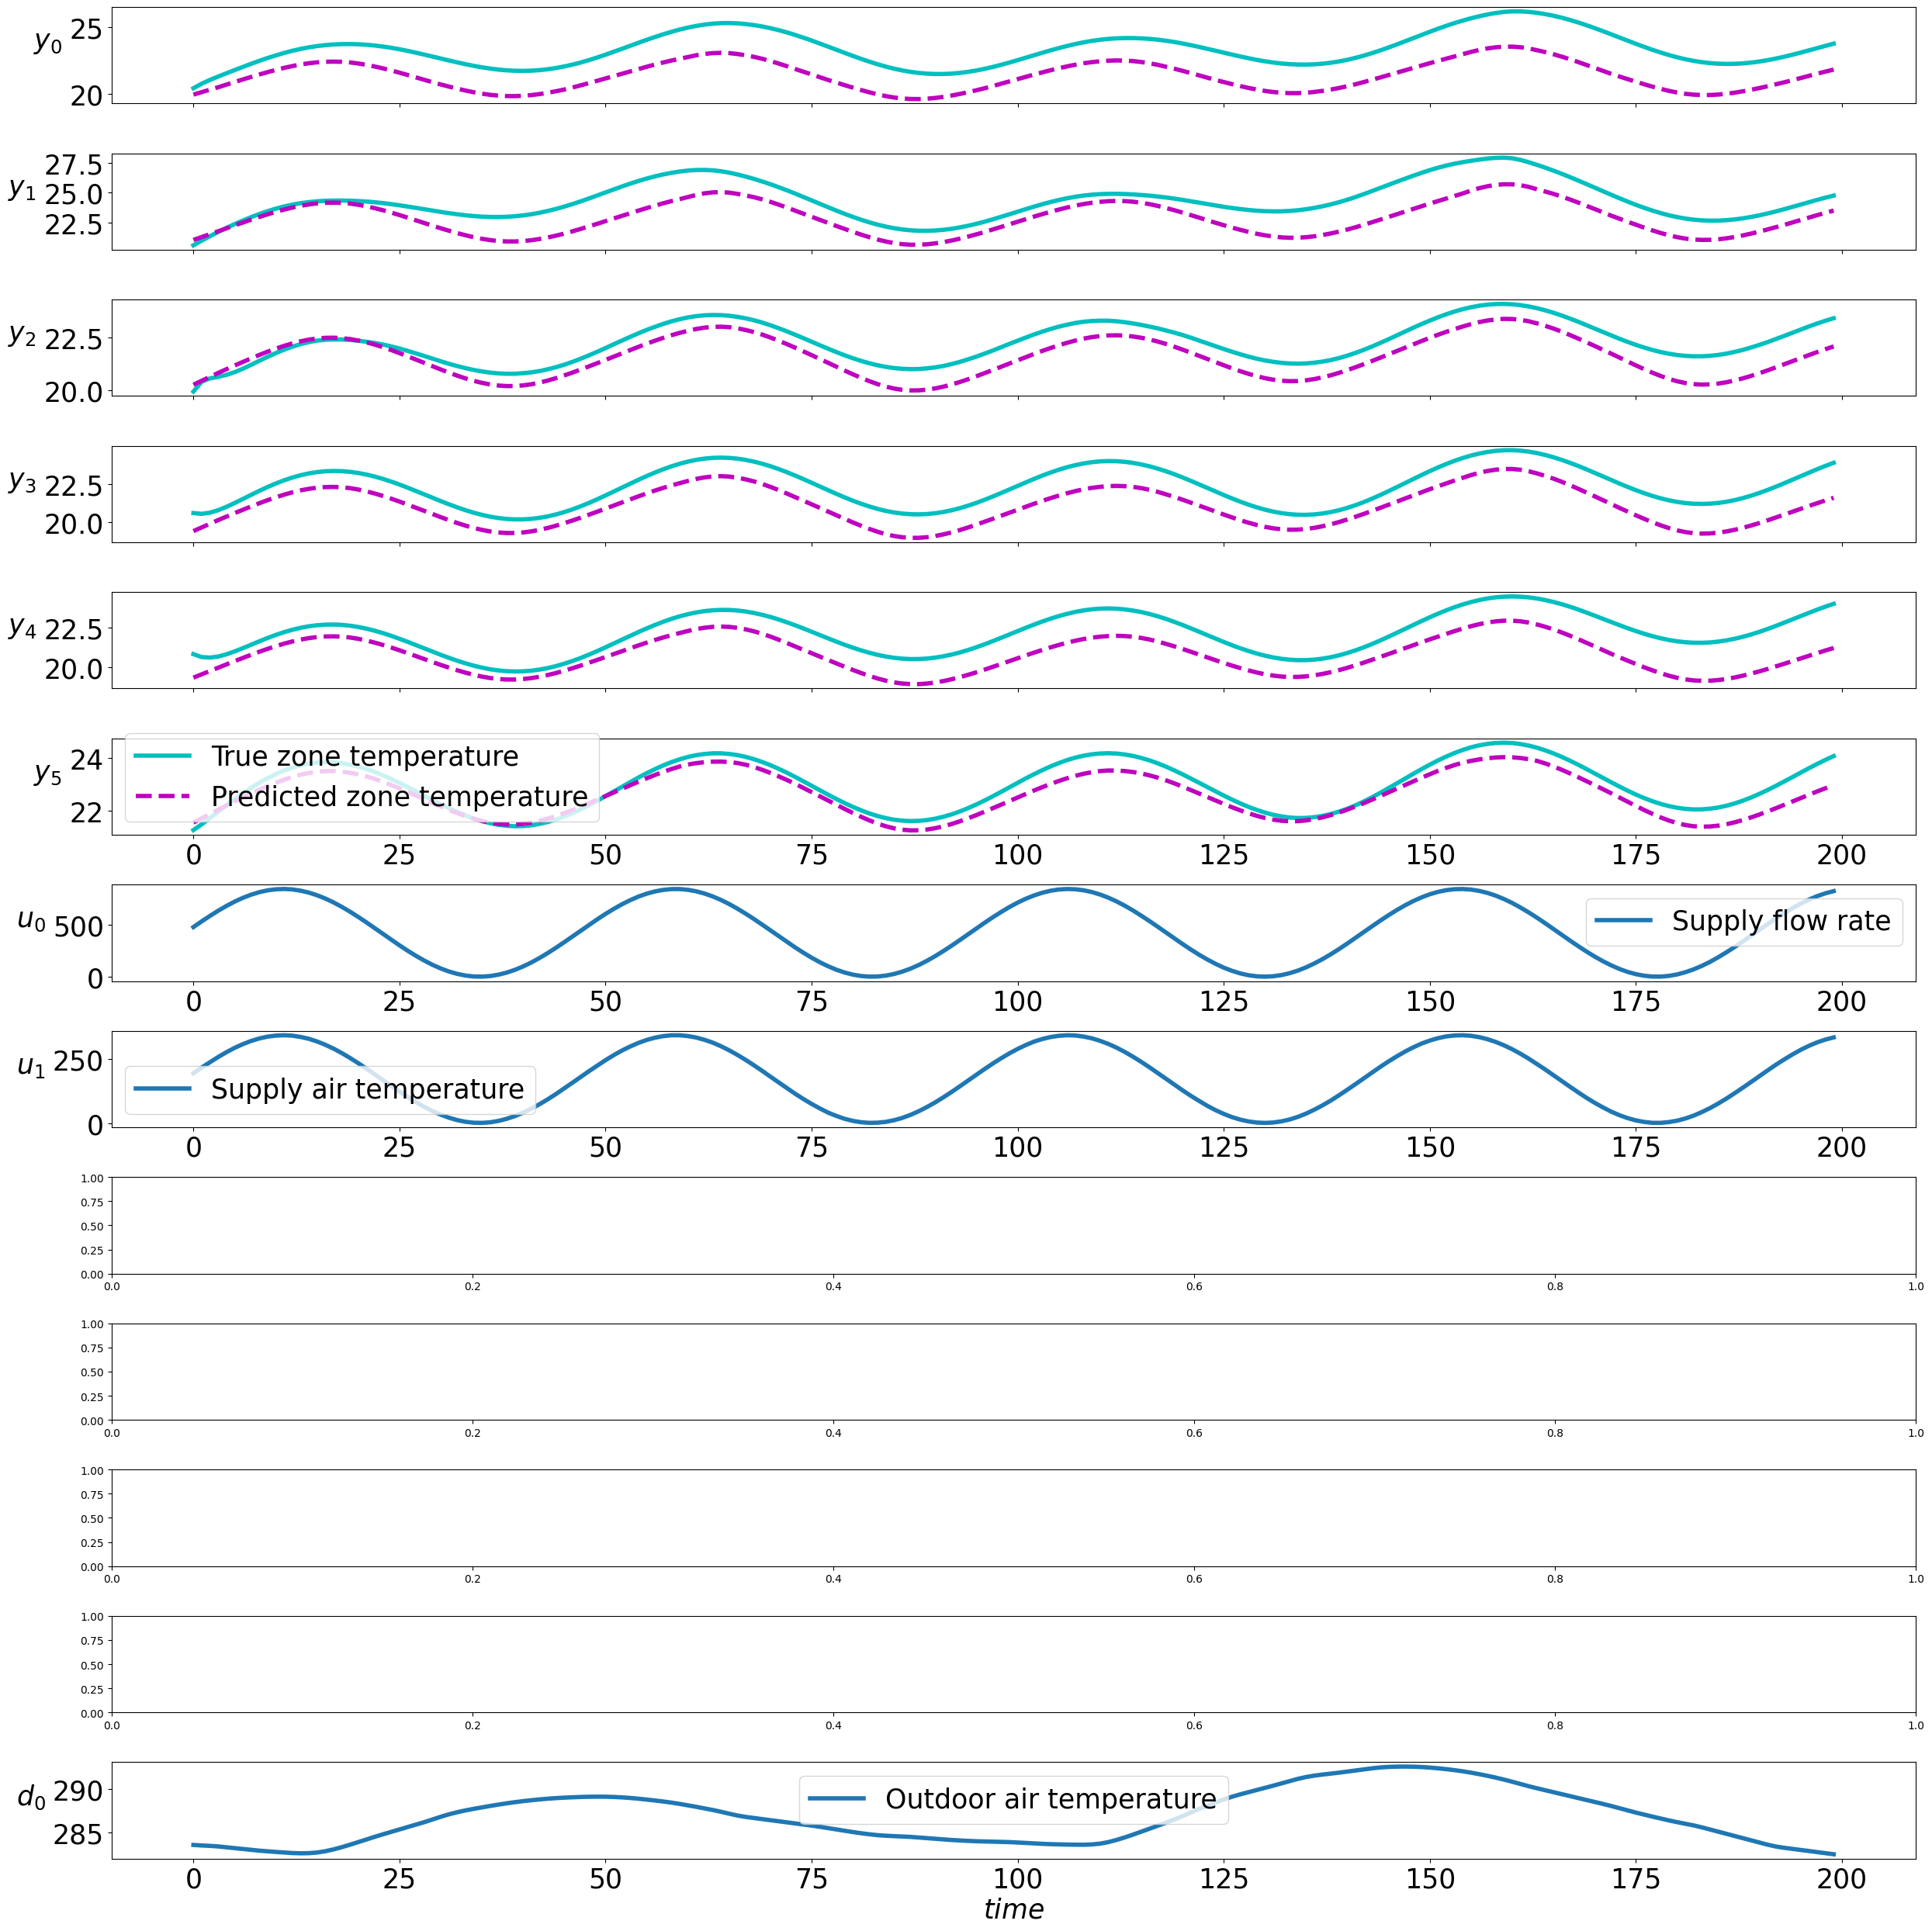

In [29]:
plt_nsteps = 200

# plot rollout
figsize = 25
fig, ax = plt.subplots(ny + nu + nd, figsize=(figsize, figsize))

x_labels = [f'$y_{k}$' for k in range(len(true_traj))]
for row, (t1, t2, label) in enumerate(zip(true_traj, pred_traj, x_labels)):
    axe = ax[row]
    axe.set_ylabel(label, rotation=0, labelpad=20, fontsize=figsize)
    axe.plot(t1[:plt_nsteps].numpy(), 'c', linewidth=4.0, label='True zone temperature')
    axe.plot(t2[:plt_nsteps], 'm--', linewidth=4.0, label='Predicted zone temperature')
    axe.tick_params(labelbottom=False, labelsize=figsize)
axe.tick_params(labelbottom=True, labelsize=figsize)
axe.legend(fontsize=figsize)

u_labels = [f'$u_{k}$' for k in range(len(input_traj))]
u_description = ['Supply flow rate', 'Supply air temperature']
for row, (u, label, description) in enumerate(zip(input_traj, u_labels, u_description)):
    axe = ax[row+ny]
    axe.plot(u[:plt_nsteps], linewidth=4.0, label=description)
    axe.legend(fontsize=figsize)
    axe.set_ylabel(label, rotation=0, labelpad=20, fontsize=figsize)
    axe.tick_params(labelbottom=True, labelsize=figsize)

d_labels = [f'$d_{k}$' for k in range(len(dist_traj))]
for row, (d, label) in enumerate(zip(dist_traj, d_labels)):
    axe = ax[row+ny+nu]
    axe.plot(d[:plt_nsteps], linewidth=4.0, label='Outdoor air temperature')
    axe.legend(fontsize=figsize)
    axe.set_ylabel(label, rotation=0, labelpad=20, fontsize=figsize)
    axe.tick_params(labelbottom=True, labelsize=figsize)

ax[-1].set_xlabel('$time$', fontsize=figsize)
plt.tight_layout()

## FOR POLICY ONLY 

In [7]:
torch.manual_seed(0)

n_samples = 3000    # number of sampled scenarios
batch_size = 128
xmin_range = torch.distributions.Uniform(18., 22.)

max_degree = 1
max_freq = 3
sparsity = 0
p = 1

theta_1 = library.FourierLibrary(ny, 2*nref+nd_obs, max_freq=max_freq, include_cos=False)
theta_2 = library.PolynomialLibrary(ny, 2*nref+nd_obs, max_degree=max_degree, interaction=False)
names = ['1', 'y0', 'y1', 'y2', 'y3', 'y4', 'y5',
        'y0_min', 'y1_min', 'y2_min', 'y3_min', 'y4_min', 'y5_min',
        'y0_max', 'y1_max', 'y2_max', 'y3_max', 'y4_max', 'y5_max',
         'd']
theta_2.function_names = names
poly_sindy = sindy.SINDy(theta_2, n_out=nu)  
four_sindy = sindy.SINDy(theta_1, n_out=nu)  



In [8]:
action_weight = 0.1
state_weight = 50.
du_weight = 0.0
u_bound_weight = 1.

def train_func(optim, system, sparsity):
    nsteps = system.nsteps
    # variables
    y = variable('y')
    u = variable('u')
    ymin_val = variable('ymin')
    ymax_val = variable('ymax')
    umin_val = variable('umin')
    umax_val = variable('umax')
    
    l = variable([y], lambda y: torch.norm(list(system.parameters())[0], p))

    loss_l = sparsity*((l == 0))
    
    action_loss = action_weight * ((u == 0.0))  # energy minimization
    du_loss = du_weight * (u[:,:-1,:] - u[:,1:,:] == 0.0)  # delta u minimization to prevent agressive changes in control actions
    
    state_lower_bound_penalty = state_weight*(y >= ymin_val)
    state_upper_bound_penalty = state_weight*(y <= ymax_val)

    u_lower_bound_penalty = u_bound_weight*(u >= umin_val)
    u_upper_bound_penalty = u_bound_weight*(u <= umax_val)

    constraints = [state_lower_bound_penalty, state_upper_bound_penalty, u_lower_bound_penalty, u_upper_bound_penalty]
    objectives = [action_loss, loss_l]
    
    components = [system]

    train_loader, dev_loader = [
            get_policy_data(gt_model, nsteps, n_samples, xmin_range, batch_size, name=name)
            for name in ("train", "dev")]   
    loss = PenaltyLoss(objectives, constraints)
    problem = Problem(components, loss)
    trainer = Trainer(
        problem,
        train_loader,
        dev_loader,
        optimizer=optim,
        epochs=350,
        train_metric='train_loss',
        eval_metric='dev_loss',
        patience=300,
        epoch_verbose=1,
        device=dev
    )
    
    # Train control policy
    best_model = trainer.train()
    
    # load best trained model
    trainer.model.load_state_dict(best_model)


    system.nsteps = nsteps
    trainer.badcount = 0



In [9]:
nsteps = 100
u_bound_node = Node(lambda u: torch.clamp(u, umin, umax), ['u_un'], ['u'])
policy_node = Node(poly_sindy,  ['y', 'R'], ['u']).to(dev)
combined_y = Node(lambda ymin, ymax, d: torch.cat([ymin, ymax, d], dim=-1),
              ['ymin', 'ymax', 'd_obs'], ['R'], name="y")
ssm = Node(ssm_forward, ['x', 'u', 'd'], ['x', 'y'])
poly_system = System([dist_obs, combined_y, policy_node, ssm],
                nsteps=nsteps,
                name='sindy_system').to(dev)
optimizer = torch.optim.AdamW(poly_sindy.parameters(), lr=.06)

In [10]:
torch.cuda.empty_cache()


In [11]:
train_func(optimizer, poly_system, sparsity)

/home/alireza/neuromancer/neuromancer/neuromancer_RL/src/neuromancer/constraint.py:169: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([128, 100, 20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.l1_loss(left, right)
/home/alireza/neuromancer/neuromancer/neuromancer_RL/src/neuromancer/constraint.py:169: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([56, 100, 20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.l1_loss(left, right)


epoch: 0  train_loss: 74.56587982177734
epoch: 1  train_loss: 48.33097457885742
epoch: 2  train_loss: 43.516326904296875
epoch: 3  train_loss: 40.559417724609375
epoch: 4  train_loss: 38.071170806884766
epoch: 5  train_loss: 36.034751892089844
epoch: 6  train_loss: 34.37565994262695
epoch: 7  train_loss: 33.025177001953125
Interrupted training loop.
